1. Read in all of the predicted (major topic) congress speech data (from multiple files. keep just party, cong_number, text, date, topic)
2. Keep only rows where party == democrat or republican 
3. Partition the data by major topic. 
4. Chunk into 2.5k character length rows
5. Tokenize:
	a. Remove Roberts Rules tokens
	b. Keep only tokens in the news data
	c. Only tokens that appear in 10 documents or more
6. Within each topic, predict party. Use Elastic Net. 
7. This will give you 21 models --- one for each topic
8. Output classification success of each.
9. Output top 20 Republican and Democrat words for each model.


In [1]:
import pandas as pd
import numpy as np
import time

In [42]:
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
import re
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#def tokenize(text):
#    tokens = nltk.word_tokenize(text)
#    stems = stem_tokens(tokens, stemmer)
#    return stems

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

%matplotlib inline
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split

with open('../roberts_rules/all_text.txt', 'rt') as f:
    text = f.read()
text = text.decode('ascii', 'ignore')
text = re.sub(r'\d+', '', text)

vect = CountVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(2, 3)) 
vect.fit([text])
roberts_rules = set(vect.get_feature_names())

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print classlabel, feat, coef

def most_informative_feature_for_class_svm(vectorizer, classifier,  n=10):
    labelid = 3 # this is the coef we're interested in. 
    feature_names = vectorizer.get_feature_names()
    svm_coef = classifier.coef_.toarray() 
    topn = sorted(zip(svm_coef[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print feat, coef

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " | ".join(feature_names[j] for j in top10)))

def get_top_features(vectorizer, clf, class_labels, n=20):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_features = {}
    for i, class_label in enumerate(class_labels):
        topN = np.argsort(clf.coef_[i])[-n:]
        top_features[class_label] = [feature_names[j] for j in topN][::-1]
    return top_features

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-20s\t\t%.4f\t%-20s" % (coef_1, fn_1, coef_2, fn_2)

## Read Predicted Congress dataset

In [3]:
adf = None
for nth in range(107, 113):
    print nth
    df = pd.read_csv('../data/congress_%d_predict_major_label.csv' % nth) #, nrows=10)
    if adf is None:
        adf = df
    else:
        adf = pd.concat([adf, df])
adf

107
108
109
110
111
112


,date,text,party,topic,cong_number
0,2002-03-19,mr speaker yield minut gentleman virginia mr m...,100,20,107
1,2002-11-19,mr speaker would like submit appropri congress...,100,21,107
2,2002-06-06,mr speaker yesterday flight lo angel delay dep...,100,1,107
3,2002-03-06,mr speaker earlier today unabl cast vote two r...,100,3,107
4,2002-04-16,mr speaker thank gentleman yield time mr speak...,100,20,107
5,2002-10-01,mr speaker yield minut gentlewoman new york ms...,100,15,107
6,2001-10-16,mr speaker friday octob unavoid miss two roll ...,100,7,107
7,2002-05-09,mr chairman although disappoint rule bodi rise...,100,16,107
8,2002-10-01,mr speaker yield minut gentlewoman texa ms edd...,100,19,107
9,2002-10-01,mr speaker yield minut gentleman new jersey mr...,100,20,107


In [4]:
df = df[df.party.isin([100, 200])]

## Split long bill to smaller chunk (2500 chars)

In [5]:
import re
import textwrap

def insert_chars_split_marker(text, cc=2500):
    # FIXME: text still has number
    text = re.sub('\d+', '', text)
    out = '|'.join(textwrap.wrap(text, cc))
    return out

def insert_words_split_marker(text, wc=500):
    text = re.sub('\d+', '', text)
    words = text.split()
    out = ''
    for i, w in enumerate(words):
        if i != 0 and i % wc == 0:
            out += '|' + w
        else:
            out += ' ' + w
    return out

In [6]:
def remove_roberts_rules(all_vocab):
    vocab = []
    i = 0
    for a in all_vocab:
        if a not in roberts_rules:
            vocab.append(a)
        else:
            #print a
            i += 1
    print("Removed {0:d}".format(i))
    print("Total {0:d}".format(len(vocab)))
    return vocab


In [18]:
for t in df.topic.unique():
    sdf = df[df.topic == t]
    print t, len(sdf)
    
    if True:
        # split long text to multiple rows
        sdf.loc[:, 'text'] = sdf.text.astype(str).apply(lambda c: insert_chars_split_marker(c, 2500))
        s = sdf['text'].str.split('|', expand=True).stack()
        i = s.index.get_level_values(0)
        new_df = sdf.loc[i].copy()
        new_df['chunk'] = s.index.get_level_values(1)
        new_df['text'] = s.values
        sdf = new_df.reset_index(drop=True)
    
    print t, len(sdf)
    vect = CountVectorizer(ngram_range=(2, 3), min_df=10) 
    vect.fit(sdf.text)
    print len(vect.get_feature_names())
    
    vocab = remove_roberts_rules(vect.vocabulary_)
    print len(vocab)
    
    ng_df = pd.DataFrame(vocab)
    ng_df.columns = ['ngram']
    ng_df['found'] = False
    
    for ndf in pd.read_csv('../data/news_predict_major.csv', iterator=True, chunksize=5000, usecols=['text']):
        text = ndf.text.str.cat(sep=' ')
        all_ng = ng_df[~ng_df.found].ngram
        print len(text), len(all_ng)
        for i, ng in enumerate(all_ng):
            if ng in text:
                ng_df.loc[ng_df.ngram == ng, 'found'] = True
                #print i, ng #, sum(ndf.text.str.contains(ng))
                #print i,
            #break
        #print
        #break
    #ng_df.to_csv('../data/major-%d-congress-23gram.csv' % t, index=False)
    print ng_df

    break

 12 3333
12 4116
7047
Removed 255
Total 6792
6792
20823174 6792
22235095 2794
28161792 2326
54750493 2079
90943891 1432
93394816 1073
89727330 894
92659177 796
93707690 721
91787021 686
87387471 658
90389833 633
90829053 616
89771329 601
90655675 586
87905876 575
89070809 559
87973382 548
89663355 543
88707351 534
71983929 526
90072337 520
89110053 519
85657873 512
89900110 505
84992070 496
73131706 490
89715208 477
89747874 467
87182483 465
85395716 464
92084309 458
83012116 453
69351893 449
20381064 444
21430350 444
21933846 439
27644394 434
24082869 427
21335966 420
20705114 415
27276330 412
28025393 411
26839291 410
27912359 405
27293987 404
27704493 403
27879033 399
30073365 396
22153147 391
22389046 390
27643790 390
47370388 390
87741199 388
89445863 387
98195297 377
98203750 373
118687207 371
124095439 371
127132127 370
129023926 369
125707758 368
119072864 364
118877059 364
119104845 364
116873475 364
109092855 360
85557316 357
83204018 350
78770403 349
24481221 336
26924235 33

In [75]:
vocab = ng_df[ng_df.found].ngram.tolist()
ng_df[ng_df.found].to_csv('../data/major_%d_congress_23gram.csv' % t, index=False)

## Model (Party)

In [105]:
X = sdf.text
y = sdf.party

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [106]:
#vect = CountVectorizer(ngram_range=(2, 3), min_df=20, vocabulary=vocab)
vect = CountVectorizer(ngram_range=(2, 3), min_df=10, vocabulary=vocab)

In [107]:
X_train = vect.transform(X_train)
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)

In [108]:
X_test = vect.transform(X_test)
transformer = TfidfTransformer()
X_test = transformer.fit_transform(X_test)

In [109]:
from sklearn.linear_model import SGDClassifier

elastic_clf = SGDClassifier(loss='log', alpha=.00002, n_iter=200, penalty="elasticnet")
t0 = time.time()
elastic_clf.fit(X_train, y_train)
t1 = time.time()
prediction_elastic = elastic_clf.predict(X_test)
t2 = time.time()
time_elastic_train = t1-t0
time_elastic_predict = t2-t1

print("Results for Elastic Net")
print("Training time: %fs; Prediction time: %fs" % (time_elastic_train, time_elastic_predict))
print(classification_report(y_test, prediction_elastic))

Results for Elastic Net
Training time: 0.509082s; Prediction time: 0.000457s
             precision    recall  f1-score   support

        100       0.78      0.83      0.80       502
        200       0.70      0.64      0.67       322

avg / total       0.75      0.75      0.75       824



In [110]:
most_informative_feature_for_class(vect, elastic_clf, 100)

100 mr cole 4.55601088164
100 even though 4.55690932931
100 commerc claus 4.59952556814
100 senat chambliss 4.72182857525
100 terrorist organ 4.74572549335
100 judici circuit 4.75984477322
100 constitut mean 4.83134698073
100 mr speaker 4.91381195429
100 ohio mr 5.18848890906
100 fast furiou 5.71843034854


In [111]:
show_most_informative_features(vect, elastic_clf, 20)

	-5.4156	minut gentlewoman   		5.7184	fast furiou         
	-5.0794	senat republican    		5.1885	ohio mr             
	-4.8601	african american    		4.9138	mr speaker          
	-4.7924	assault weapon      		4.8313	constitut mean      
	-4.7577	lost live           		4.7598	judici circuit      
	-4.7235	florida mr hast     		4.7457	terrorist organ     
	-4.6934	long island         		4.7218	senat chambliss     
	-4.6617	california mr speaker		4.5995	commerc claus       
	-4.6283	san francisco       		4.5569	even though         
	-4.5261	last week           		4.5560	mr cole             
	-4.4409	rhode island        		4.5008	district texa       
	-4.4341	republican leader   		4.4129	new hampshir        
	-4.3314	tabl amend          		4.4124	rule law            
	-4.2313	hope senat          		4.2968	took place          
	-4.2171	work senat          		4.2282	counti new jersey   
	-4.0314	west virginia       		4.1583	justic depart       
	-4.0092	mr speaker colleagu 		4.1487	crime subcommitte

In [112]:
def get_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_a = coefs_with_fns[:n]
    top_b = coefs_with_fns[:-(n + 1):-1]
    return top_a, top_b

top_a, top_b = get_most_informative_features(vect, elastic_clf, 20)
top_a_df = pd.DataFrame(top_a)
top_a_df.columns = ['coef', 'term']
top_b_df = pd.DataFrame(top_b)
top_b_df.columns = ['coef', 'term']
top_a_df.to_csv('../data/major_%s_top20_rep.csv' % t, index=False)
top_b_df.to_csv('../data/major_%s_top20_dem.csv' % t, index=False)

In [120]:
from sklearn.externals import joblib

joblib.dump(vect, "../models/major_%s_vec_count_cong_23gram.joblib" % t)
joblib.dump(elastic_clf, "../models/major_%s_cong_clf_elastic.joblib" % t)

['../models/major_12_cong_clf_elastic.joblib',
 '../models/major_12_cong_clf_elastic.joblib_01.npy',
 '../models/major_12_cong_clf_elastic.joblib_02.npy',
 '../models/major_12_cong_clf_elastic.joblib_03.npy',
 '../models/major_12_cong_clf_elastic.joblib_04.npy']

In [119]:
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_test_df['predicted'] = prediction_elastic
y_test_df.to_csv('../data/major_%s_test_prediction_party.csv' % t, index=False)

In [115]:
y_true = y_test.reset_index(drop=True)
confusion_matrix = ConfusionMatrix(y_true, prediction_elastic)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  100  200  __all__
Actual                      
100        416   86      502
200        117  205      322
__all__    533  291      824


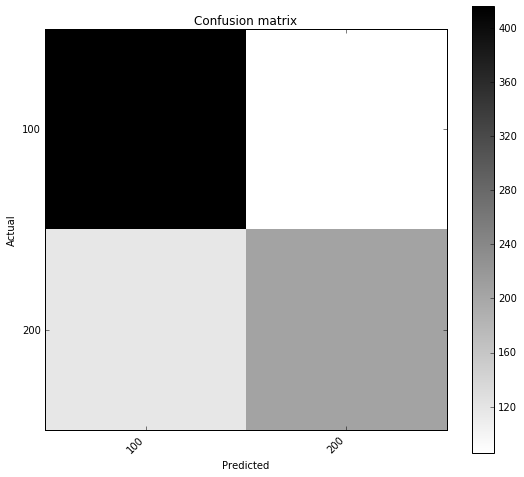

In [116]:
confusion_matrix.plot()

In [117]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_true, prediction_elastic)
conf_df = pd.DataFrame(conf)
conf_df.columns = elastic_clf.classes_
conf_df.index = elastic_clf.classes_
conf_df.to_csv('../data/major_%s_test_confusion_matrix_party.csv' % t, index_label="actual \ predicted")
conf_df

,100,200
100,416,86
200,117,205


In [124]:
df.groupby('topic').agg({'topic': 'count'})

,topic
topic,
1,3310
2,607
3,21192
4,598
5,1326
6,3038
7,1923
8,2342
10,2030
